## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [378]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [379]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [380]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [381]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [382]:
dfUniq = df.drop_duplicates('user_id')
dfUniq['converted'].mean()

0.1195695564793657

e. The number of times the `new_page` and `treatment` don't line up.

In [383]:
df.query('group == "treatment" & landing_page == "old_page"').shape[0]+\
df.query('group == "control" & landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [384]:
df.dropna().shape[0] - df.shape[0]

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [385]:
df2 = df.query('(group == "treatment" & landing_page == "new_page")\
                or (group == "control" & landing_page == "old_page")')

In [386]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [387]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [388]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [389]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [390]:
dfTemp = df2.drop(1899,axis=0)
df2 = dfTemp
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [391]:
pPopulation = df2.converted.mean()
pPopulation

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [392]:
convrRateControl = df2.query('group == "control"').converted.mean()
convrRateControl

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [393]:
convrRateTreat = df2.query('group == "treatment"').converted.mean()
convrRateTreat

0.11880806551510564

In [394]:
obsDiff = convrRateTreat - convrRateControl
obsDiff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [395]:
pNewPageRecivd = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
pNewPageRecivd

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There is not sufficient evidence in support of launching the new page. Although the percentage of people who have recieved the new page is even slightly more than the subjects who have viewed the old page, the conversion rate for this group is 0.15% lower than the control group. More statistical tests are required to confirm that the new page does not work better than the old page, but so far the evidence shows a decrease in the effectiveness of the page design with the new version.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis: The probability of the customers paying for the company's product with the old page is equal or higher than the probablity of the cusomters paying for the company's product with the new page. \
Alternative hypothesis: The probability of the customers paying for the company's product is higher with the new page relative to the old page. 

$$ H0: p_{old}>= p_{new} $$
$$ H1: p_{old}<p_{new} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [396]:
pNew = df2.converted.mean()
pNew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [397]:
pOld = df2.converted.mean()
pOld

0.11959708724499628

c. What is $n_{new}$?

In [398]:
df2Treat = df2.query('group == "treatment"')
nNew = df2Treat.shape[0]
nNew

145310

d. What is $n_{old}$?

In [399]:
df2Cntrl = df2.query('group == "control"')
nOld = df2Cntrl.shape[0]
nOld

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [400]:
newPageConverted = np.random.choice([0,1],size=nNew,p = [1-pNew,pNew])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [401]:
oldPageConverted = np.random.choice([0,1],size=nOld,p = [1-pOld,pOld])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [402]:
diffPnewPold = newPageConverted.mean() - oldPageConverted.mean()
diffPnewPold

0.0012987516477765276

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [403]:
pDiffs =[]

for _ in range(0,10000):
    pDiffs.append(np.random.choice([0,1],size=nNew,p = [1-pNew,pNew]).mean() - \
                 np.random.choice([0,1],size=nOld,p = [1-pOld,pOld]).mean())

In [404]:
pDiffs = np.array(pDiffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

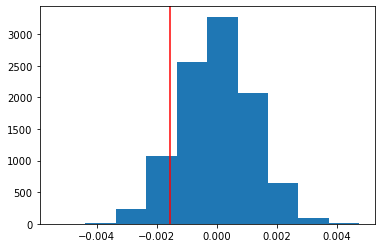

In [405]:
plt.hist(pDiffs);
plt.axvline(obsDiff,color='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [406]:
len(pDiffs[pDiffs>obsDiff])/len(pDiffs)

0.9058

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value is called the p-value and shows the probability that our observation and other extreme observations come from our null distribution. It shows that the probability of getting the observed difference and values more than that when there is no significant improvement in the conversion rate after using the new webpage is about 91%. This value is way above the 5% threshold that had been set as the tolerance for the false positive rates and therefore, we fail to reject the null hypothesis and cannot claim that conversion rate with new webpage is higher than this rate with the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [407]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [408]:
[zscore,pval] = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')

In [409]:
zscore

-1.3109241984234394

In [410]:
pval

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The pvalue is more than 5%, the threshold for fasle positive rate. Therefore, the null hypothesis cannot be rejected and we cannot conclude that the probability of conversion with new page is more than the probablity of conversion with the old page. This means that the new page is not more effective in attracting new customers than the old page. \
The results of the z-test agree with the previous results and the p-value in both of them is about 90%.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [411]:
df2['intercept'] = 1
df2[['temp','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('temp',axis=1,inplace=True)

In [412]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [413]:
logModel = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logModel.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [414]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-10-24 21:13 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value here is 0.1897 which is more than 5% threshold. This means that the estimated coefficient for the ab_page is not significantly different from 0 and the probability of conversion is not affected by the design of the page. \
The p-value is not similar to the estimated value with the hypothesis testing because here the null hypothesis is having a coefficient equal to 0 and alternative is that the coefficient is not zero, without any direction. In hypothsis testing, for the alternative case we had a one-sided p-value, but here as the result of the inequality in the alternative the p-value is two-sided.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Based on the results, the page design by itself cannot affect the customers' opinions in purchsing the product in general. But it is possible that the change in design affects certain groups of customers. To investigate this further we can add other parameters to the model.\
In adding parameters to the model two points should be considered: 1) Adding too many parameters to the model and increasing the complexity more than a certain degree may cause overfitting and possible poor prediction. 2) Parameters should not be correlated. If additional parameters are selected by taking into account these points, there is no disadvantage to additing additional terms.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [415]:
countries_df = pd.read_csv('./countries.csv')
dfNew = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
dfNew.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [416]:
dfNew.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [417]:
### Create the necessary dummy variables

In [418]:
dfNew['intercept'] = 1
dfNew[['CA','UK','US']] = pd.get_dummies(dfNew['country'])
dfNew.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [419]:
logModel = sm.Logit(dfNew['converted'],dfNew[['intercept','CA','UK','ab_page']])
results = logModel.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-10-24 21:13 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

The p-values for the coefficients of both CA and UK countries are more than 5%. This means that the probability of customers purchasing from the website does not change significantly between countries. Therefore, the answer is no and country by itself does not affect conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [420]:
### Fit Your Linear Model And Obtain the Results

In [421]:
dfNew['CA_ab'] = dfNew['CA']*dfNew['ab_page']
dfNew['UK_ab'] = dfNew['UK']*dfNew['ab_page']
dfNew['US_ab'] = dfNew['US']*dfNew['ab_page']
dfNew['CA_not_ab'] = dfNew['CA']*(1-dfNew['ab_page'])
dfNew['UK_not_ab'] = dfNew['UK']*(1-dfNew['ab_page'])
dfNew.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab,UK_ab,US_ab,CA_not_ab,UK_not_ab
user_id,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0,0,0


In [422]:
logModel = sm.Logit(dfNew['converted'],dfNew[['intercept','CA_ab','UK_ab','US_ab',\
                                             'CA_not_ab','UK_not_ab']])
results = logModel.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-10-24 21:13 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA_ab        -0.0850    0.0384    -2.2157  0.0267  -0.1601  -0.0098
UK_ab         0.0051    0.0188     0.2710  0.7864  -0.0317   0.0419
US_ab        -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA_not_ab    -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_not_ab    -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

In [423]:
np.exp(results.params)

intercept    0.137178
CA_ab        0.918534
UK_ab        1.005103
US_ab        0.979646
CA_not_ab    0.982625
UK_not_ab    0.994272
dtype: float64

From the table above, we can see that the only coefficient that is significantly different than 0, is the coefficient of CA and new page with a p-value of 0.0267. But the value of this coefficient is close to 0 and therefore, the probability of conversion in the US and with the old page (intercept in the model) is almost equal to the probability of conversion in Canada and with the new page. As a result, the model above does not support the notion that the conversion rate is affected by the page design differently in different countries.